## Step 1: Load & clean the data. 
Adding new columns, dealing with timestamps.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
contacts = pd.read_csv("../Data/contacts.csv")
listings = pd.read_csv("../Data/listings.csv")
users = pd.read_csv("../Data/users.csv")
df = pd.merge(contacts, listings, how = 'left', on='id_listing_anon')
df = pd.merge(df, users, how = 'left', left_on='id_guest_anon', right_on= 'id_user_anon')

for n in ['ts_interaction_first','ts_reply_at_first','ts_accepted_at_first',\
          'ts_booking_at','ds_checkin_first', 'ds_checkout_first']:
    df[n] = pd.to_datetime(df[n])

df['booked'] = df['ts_booking_at'].notnull()
df['time_interaction_booking'] = df['ts_booking_at'] - df['ts_interaction_first']
df['time_interaction_reply'] = df['ts_reply_at_first'] - df['ts_interaction_first']
df['time_reply_accepted'] = df['ts_accepted_at_first'] - df['ts_reply_at_first']
df['time_accepted_booking'] = df['ts_booking_at'] - df['ts_accepted_at_first']
df['request_days_before_arrival'] = (df['ds_checkin_first']+ pd.Timedelta(hours=23, minutes=59) \
                                     - df['ts_interaction_first'])/ pd.Timedelta(days=1)
df['stay_length'] = (df['ds_checkout_first']-df['ds_checkin_first'])/pd.Timedelta(days=1)

for x in ['time_interaction_booking', 'time_interaction_reply', 'time_reply_accepted', 'time_accepted_booking']:
    df[x] = df[x] / pd.Timedelta(hours=1)
df = df[~(df['time_interaction_reply']>120) & ~(df['time_interaction_booking'] >120) \
        & ~(df['time_reply_accepted']>120) & ~(df['time_interaction_booking'] <0)\
        & ~(df['time_interaction_reply'] <0) & ~(df['request_days_before_arrival']<0)\
        &~(df['request_days_before_arrival']>365) &\
        ~(df['stay_length'] >120)]#removed outliers >5 days & invalid entires
df['total_reviews'][df['total_reviews']<0] = 0 #negative number of reviews = 0 reviews
df = df.drop(['id_user_anon', 'ts_accepted_at_first', 'ts_reply_at_first'], axis=1)
df.head(2)

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests,m_interactions,m_first_message_length_in_characters,...,total_reviews,country,words_in_user_profile,booked,time_interaction_booking,time_interaction_reply,time_reply_accepted,time_accepted_booking,request_days_before_arrival,stay_length
0,da8656a1-51af-4f38-b1c4-94be1f585157,5426897d-960d-4013-9e38-606ae746793c,a408a8b2-0d44-4513-a611-3736d0409bb2,2016-04-21 02:55:53,2016-04-21 03:15:00,2016-08-02,2016-08-06,4.0,30,31.0,...,9.0,CL,0,True,0.318611,0.318611,0.0,0.0,103.877164,4.0
1,8590d6f1-8bc9-4e8b-bdfb-de78f69fcf37,f30417c5-6df4-45ac-bfc2-6ad1cce398ab,e387c705-0aeb-464c-9375-ece63be6f006,2016-02-16 22:14:01,NaT,2016-08-11,2016-08-22,5.0,2,312.0,...,0.0,FR,0,False,NaN,1.393056,NaN,NaN,177.072905,11.0


In [2]:
df['id_guest_anon'].nunique()

21812

In [3]:
df['id_listing_anon'].count()

26787

In [4]:
df.columns

Index(['id_guest_anon', 'id_host_anon', 'id_listing_anon',
       'ts_interaction_first', 'ts_booking_at', 'ds_checkin_first',
       'ds_checkout_first', 'm_guests', 'm_interactions',
       'm_first_message_length_in_characters', 'contact_channel_first',
       'guest_user_stage_first', 'room_type', 'listing_neighborhood',
       'total_reviews', 'country', 'words_in_user_profile', 'booked',
       'time_interaction_booking', 'time_interaction_reply',
       'time_reply_accepted', 'time_accepted_booking',
       'request_days_before_arrival', 'stay_length'],
      dtype='object')

## Step 2: Exploratory analysis

### 2a: Statistics of the successful and unsuccesful bookings

In [5]:
booking_stat = df.groupby(['booked']).agg(\
                                {'id_guest_anon': ['count', 'nunique'],
                                 'm_interactions': ['median','mean'],
                                 'm_first_message_length_in_characters': ['median','mean'],
                                 'words_in_user_profile': 'mean',
                                 'total_reviews': ['median','mean'],
                                 'stay_length':'mean',
                                 'request_days_before_arrival': 'mean',
                                 'time_interaction_booking': 'mean',
                                 'time_interaction_reply': 'mean',
                                 'time_reply_accepted': 'mean'})
booking_stat.iloc[:, 0:8].round(decimals=2) 

id_guest_anon         m_interactions         \
               count nunique         median   mean   
booked                                               
False          15549   12249              3   4.74   
True           11238   10595             10  12.91   

       m_first_message_length_in_characters         words_in_user_profile  \
                                     median    mean                  mean   
booked                                                                      
False                                 168.0  211.86                  8.83   
True                                  134.0  170.15                 12.39   

       total_reviews  
              median  
booked                
False            1.0  
True            12.0

#### continued table above

In [6]:
booking_stat.iloc[:, 8:20].round(decimals=2)

,total_reviews,stay_length,request_days_before_arrival,time_interaction_booking,time_interaction_reply,time_reply_accepted
,mean,mean,mean,mean,mean,mean
booked,,,,,,
False,8.93,8.16,82.26,NaN,9.55,4.41
True,25.46,5.19,52.68,5.09,1.93,1.91


### 2b: Statistics of the successful and unsuccesful bookings in more details

In [7]:
#Statistics of successful bookings
booked = df[df['booked'] == True].describe()
booked.iloc[:, 0:6].round(decimals=2)

,m_guests,m_interactions,m_first_message_length_in_characters,total_reviews,words_in_user_profile,time_interaction_booking
count,11238.00,11238.00,11238.00,11238.00,11238.00,11238.00
mean,2.49,12.91,170.15,25.46,12.39,5.09
std,1.53,12.27,179.23,34.14,35.93,13.82
min,0.00,2.00,0.00,0.00,0.00,0.00
25%,2.00,6.00,21.00,2.00,0.00,0.00
50%,2.00,10.00,134.00,12.00,0.00,0.04
75%,3.00,16.00,249.00,37.00,4.00,1.93
max,16.00,410.00,2341.00,268.00,658.00,119.84


In [8]:
#continued table above
booked.iloc[:, 6:20].round(decimals=2)

,time_interaction_reply,time_reply_accepted,time_accepted_booking,request_days_before_arrival,stay_length
count,11238.00,11238.00,11238.00,11238.00,11238.00
mean,1.93,1.91,1.24,52.68,5.19
std,5.50,8.82,7.67,61.82,5.08
min,0.00,0.00,0.00,0.02,1.00
25%,0.00,0.00,0.00,7.15,3.00
50%,0.03,0.00,0.00,28.14,4.00
75%,0.81,0.00,0.00,74.92,6.00
max,100.48,115.54,119.34,360.93,99.00


In [9]:
#Statistics of unsuccessful bookings
unbooked = df[df['booked'] == False].describe()
unbooked.iloc[:, 0:6].round(decimals=2)

,m_guests,m_interactions,m_first_message_length_in_characters,total_reviews,words_in_user_profile,time_interaction_booking
count,15548.00,15549.00,15549.00,15549.00,15549.00,0.0
mean,2.99,4.74,211.86,8.93,8.83,NaN
std,2.03,5.36,183.59,19.34,27.20,NaN
min,0.00,1.00,0.00,0.00,0.00,NaN
25%,2.00,2.00,90.00,0.00,0.00,NaN
50%,2.00,3.00,168.00,1.00,0.00,NaN
75%,4.00,5.00,283.00,8.00,1.00,NaN
max,16.00,153.00,1948.00,268.00,482.00,NaN


In [10]:
#continued table above
unbooked.iloc[:, 6:20].round(decimals=2)

,time_interaction_reply,time_reply_accepted,time_accepted_booking,request_days_before_arrival,stay_length
count,13520.00,4463.00,0.0,15549.00,15549.00
mean,9.55,4.41,NaN,82.26,8.16
std,16.10,13.91,NaN,76.49,10.69
min,0.00,0.00,NaN,0.00,1.00
25%,0.50,0.00,NaN,19.44,3.00
50%,3.21,0.00,NaN,53.43,5.00
75%,11.89,0.14,NaN,138.93,9.00
max,119.75,118.65,NaN,364.01,119.00


### 2c: Other statistics 

#### Percentage of succesful bookings by country

In [11]:
stat_by_country = df.groupby(['country']).agg(\
                               {'id_guest_anon': 'nunique',
                                 'booked': 'mean'})
stat_by_country = stat_by_country.sort_values(by=['id_guest_anon'], ascending=False)
stat_by_country.round(2).head(10)

,id_guest_anon,booked
country,,
BR,10433,0.31
US,2734,0.59
AR,1709,0.30
FR,1118,0.59
GB,940,0.59
DE,590,0.64
CL,396,0.47
CA,378,0.55
AU,357,0.58


#### Percentage of succesful bookings and statistics by new/past user

In [12]:
stat_by_usertype = df.groupby(['guest_user_stage_first']).agg(\
                               {'id_guest_anon': ['count', 'nunique'],
                                 'booked': 'mean',
                                 'words_in_user_profile': 'mean',
                                 'time_interaction_booking': 'mean'})
#stat_by_usertype = stat_by_usertype.sort_values(by=['id_guest_anon'], ascending=False)
stat_by_usertype = stat_by_usertype.drop(['-unknown-'], axis=0)
stat_by_usertype.round(2)

id_guest_anon         booked words_in_user_profile  \
                               count nunique   mean                  mean   
guest_user_stage_first                                                      
new                            15208   12833   0.33                  5.54   
past_booker                    11546    9390   0.53                 16.61   

                       time_interaction_booking  
                                           mean  
guest_user_stage_first                           
new                                        6.50  
past_booker                                3.91

#### Percentage of succesful bookings and stats by contact channel

In [13]:
booking_stat = df.groupby(['booked', 'contact_channel_first']).agg(\
                               {'id_guest_anon': 'count',
                                 'm_interactions': ['median','mean'],
                                 'm_first_message_length_in_characters': ['median','mean'],
                                 'words_in_user_profile': ['mean'],
                                 'total_reviews': ['median','mean'],
                                 'stay_length':'mean',
                                 'request_days_before_arrival': ['mean'],
                                 'time_interaction_booking': 'mean',
                                 'time_interaction_reply': ['mean'],
                                 'time_reply_accepted': ['mean']})

booking_stat.iloc[:, 0:8].round(decimals=2)

id_guest_anon m_interactions         \
                                     count         median   mean   
booked contact_channel_first                                       
False  book_it                        4268              3   4.51   
       contact_me                    11281              3   4.83   
True   book_it                        3795             11  13.49   
       contact_me                      761             17  21.43   
       instant_book                   6682              9  11.61   

                             m_first_message_length_in_characters          \
                                                           median    mean   
booked contact_channel_first                                                
False  book_it                                              123.0  165.35   
       contact_me                                           182.0  229.46   
True   book_it                                              131.0  169.15   
       contact_me                                           237.0  278.41   
       instant_book                                         122.0  158.39   

                             words_in_user_profile total_reviews         
                                              mean        median   mean  
booked contact_channel_first                                             
False  book_it                               11.04           1.0   8.82  
       contact_me                             8.00           1.0   8.97  
True   book_it                               12.35          12.0  22.98  
       contact_me                            10.59           6.0  16.86  
       instant_book                          12.62          13.0  27.86

In [14]:
#continued table above
booking_stat.iloc[:, 8:20].round(decimals=2)

stay_length request_days_before_arrival  \
                                    mean                        mean   
booked contact_channel_first                                           
False  book_it                      6.59                       83.26   
       contact_me                   8.76                       81.88   
True   book_it                      5.76                       49.44   
       contact_me                   6.88                       57.81   
       instant_book                 4.67                       53.94   

                             time_interaction_booking time_interaction_reply  \
                                                 mean                   mean   
booked contact_channel_first                                                   
False  book_it                                    NaN                   9.80   
       contact_me                                 NaN                   9.47   
True   book_it                                   8.88                   4.30   
       contact_me                               27.35                   4.16   
       instant_book                              0.40                   0.33   

                             time_reply_accepted  
                                            mean  
booked contact_channel_first                      
False  book_it                              8.95  
       contact_me                           4.15  
True   book_it                              4.21  
       contact_me                           6.76  
       instant_book                         0.06

In [15]:
#Percent of successful bookings by channel type
booking_stat_channel = df.groupby(['contact_channel_first']).agg(\
                               {'id_guest_anon': 'count',
                                 'booked': ['mean']})
booking_stat_channel.round(2)

,id_guest_anon,booked
,count,mean
contact_channel_first,,
book_it,8063,0.47
contact_me,12042,0.06
instant_book,6682,1.00


#### Percentage of succesful bookings and stats by room_type

In [16]:
booking_stat = df.groupby(['room_type']).agg(\
                               {'id_guest_anon': ['count', 'nunique'],
                                 'booked': 'mean', 
                                  'id_host_anon': ['nunique'],
                               'id_listing_anon': ['count', 'nunique']})
booking_stat.round(2)

id_guest_anon         booked id_host_anon id_listing_anon  \
                        count nunique   mean      nunique           count   
room_type                                                                   
Entire home/apt         20162   16596   0.41         6497           20162   
Private room             6059    5329   0.48         2371            6059   
Shared room               566     540   0.33          263             566   

                         
                nunique  
room_type                
Entire home/apt    9201  
Private room       2876  
Shared room         359

### 2d: Statistics of the guests and hosts
#### Stats by guest

In [17]:
guest_stat = df.groupby(['id_guest_anon']).agg(\
                               {'id_listing_anon': ['count', 'nunique'], 'id_host_anon':['count', 'nunique'],
                                 'booked': 'mean',
                                'm_interactions': ['median','mean'],
                                 'm_first_message_length_in_characters': ['median','mean'],
                                 'words_in_user_profile': ['mean'],
                                 'total_reviews': ['median','mean'],
                                 'stay_length':'mean',
                                 'request_days_before_arrival': ['mean'],
                                 'time_interaction_booking': 'mean',
                                 'time_interaction_reply': ['mean'],
                                 'time_reply_accepted': ['mean']})
guest_stat = guest_stat.sort_values(by=('id_listing_anon','count'),  ascending=False).reset_index()
guest_stat.iloc[:, 0:10].round(2).head(2)

id_guest_anon id_listing_anon         id_host_anon  \
                                                  count nunique        count   
0  25940fca-7aa9-480d-9cf0-56cc1136d30c              38      38           38   
1  9ba5e5af-9de6-4584-9052-aa8d5709bd46              16      16           16   

          booked m_interactions       m_first_message_length_in_characters  \
  nunique   mean         median  mean                               median   
0      38    0.0            3.0  4.18                                359.0   
1      15    0.0            2.0  2.38                                348.5   

           
     mean  
0  334.92  
1  379.81

In [18]:
#continued table above
guest_stat.iloc[:, 10:30].round(2).head(2)

words_in_user_profile total_reviews       stay_length  \
                   mean        median  mean        mean   
0                     0           1.0  8.37        5.16   
1                     1           0.0  0.69        1.06   

  request_days_before_arrival time_interaction_booking time_interaction_reply  \
                         mean                     mean                   mean   
0                       17.79                      NaN                  12.98   
1                      196.68                      NaN                  16.14   

  time_reply_accepted  
                 mean  
0               15.89  
1                 NaN

#### Stats by host

In [19]:
host_stat = df.groupby(['id_host_anon']).agg(\
                               {'id_guest_anon': ['count', 'nunique'],  'id_listing_anon': 'nunique',
                                 'booked': 'mean',
                                'm_interactions': ['median','mean'],
                                 'm_first_message_length_in_characters': ['median','mean'],
                                 'words_in_user_profile': ['mean'],
                                 'total_reviews': ['median','mean'],
                                 'stay_length':'mean',
                                 'request_days_before_arrival': ['mean'],
                                 'time_interaction_booking': 'mean',
                                 'time_interaction_reply': ['mean'],
                                 'time_reply_accepted': ['mean']})
host_stat = host_stat.sort_values(by=('id_guest_anon','count'),  ascending=False).reset_index()
host_stat.iloc[:, 0:9].round(2).head(2)

id_host_anon id_guest_anon         id_listing_anon  \
                                                count nunique         nunique   
0  261917c5-0378-4a79-bce6-de34ce54034a           195     192              38   
1  8be2ded2-fb4f-4230-ba9d-fbd583b98d42           146     144              32   

  booked m_interactions       m_first_message_length_in_characters          
    mean         median  mean                               median    mean  
0   0.04            3.0  3.81                                146.0  180.56  
1   0.03            3.0  3.85                                149.0  192.53

In [20]:
#continued table above
host_stat.iloc[:, 9:30].round(2).head(2)

words_in_user_profile total_reviews        stay_length  \
                   mean        median   mean        mean   
0                  8.32          12.0  14.91        5.47   
1                  9.29           0.0   4.60        7.25   

  request_days_before_arrival time_interaction_booking time_interaction_reply  \
                         mean                     mean                   mean   
0                       88.66                     6.66                   3.12   
1                       74.41                    13.75                   3.79   

  time_reply_accepted  
                 mean  
0                7.17  
1               10.00

#### Number of listings per host
Histogram is limited by number of listings on Y axis to 100.

In [21]:
number_listings_percentage = host_stat['id_listing_anon'].reset_index()
number_listings_percentage['nunique'].value_counts(normalize=True).head(10)

1     0.826714
2     0.104613
3     0.032048
4     0.011789
5     0.006753
6     0.003891
7     0.002861
9     0.001831
10    0.001602
8     0.001373
Name: nunique, dtype: float64

Text(0.5,1,'Number of listings per host')

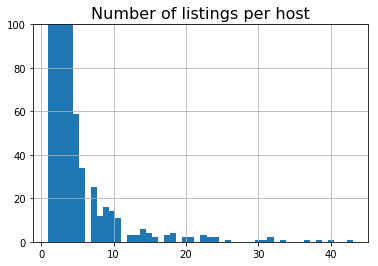

In [22]:
host_stat['id_listing_anon'].hist(bins=50)
plt.ylim(0,100)
plt.title('Number of listings per host', fontsize = 16, color = "Black")

## 3: Plots and grapths

([<matplotlib.axis.XTick at 0x10d26d400>,
 <a list of 6 Text xticklabel objects>)

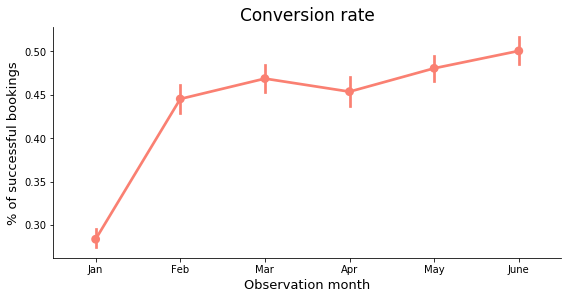

In [23]:
df['inq_month'] = pd.DatetimeIndex(df['ts_interaction_first']).month
g=sns.factorplot(x = 'inq_month', y='booked', data=df, size=4, aspect=2, color='salmon')
plt.xlabel('Observation month', color = "Black", fontsize = 13)
plt.ylabel('% of successful bookings', color = "Black", fontsize = 13)
plt.title('Conversion rate', fontsize = 17, color = "Black")
plt.xticks(np.arange(6), ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'June'))

([<matplotlib.axis.XTick at 0x1077cf128>,
 <a list of 6 Text xticklabel objects>)

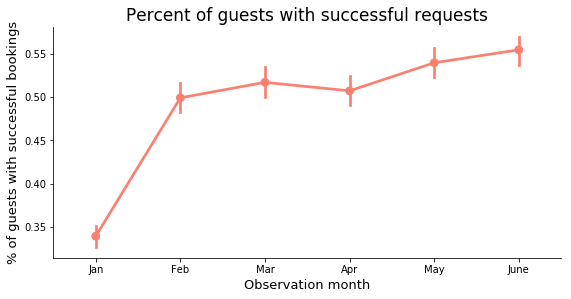

In [24]:
df_by_guest_month = df.groupby(['inq_month', 'id_guest_anon']).agg(\
                               {'ts_interaction_first': 'count',
                                 'booked': 'max'}).reset_index()
g=sns.factorplot(x = 'inq_month', y='booked', data=df_by_guest_month, size=4, aspect=2, color='salmon')
plt.xlabel('Observation month', color = "Black", fontsize = 13)
plt.ylabel('% of guests with successful bookings', color = "Black", fontsize = 13)
plt.title('Percent of guests with successful requests', fontsize = 17, color = "Black")
plt.xticks(np.arange(6), ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'June'))

Text(0.5,1,'Booking success and length of stay')

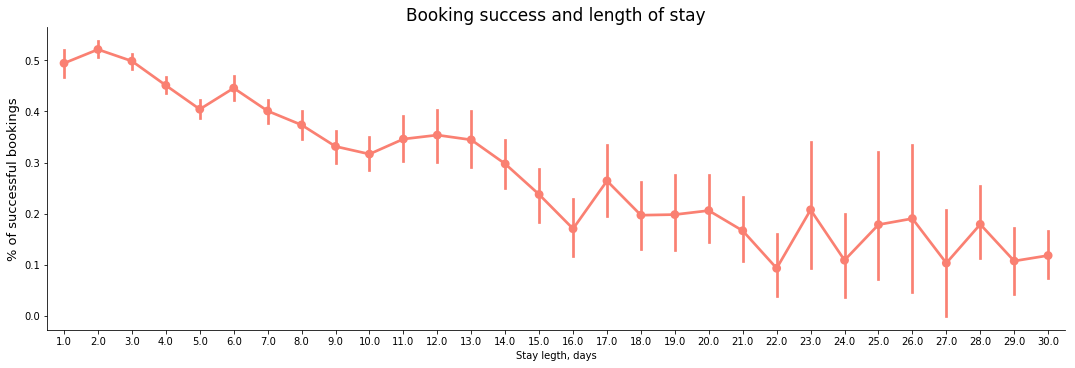

In [25]:
g=sns.factorplot(x = 'stay_length', y='booked', data=df[df['stay_length']<31], size=5, aspect=3, color='salmon')
plt.xlabel('Stay legth, days', color = "Black")
plt.ylabel('% of successful bookings', color = "Black", fontsize = 13)
plt.title('Booking success and length of stay', fontsize = 17, color = "Black")

Text(0.5,1,'Booking success and advance reservation')

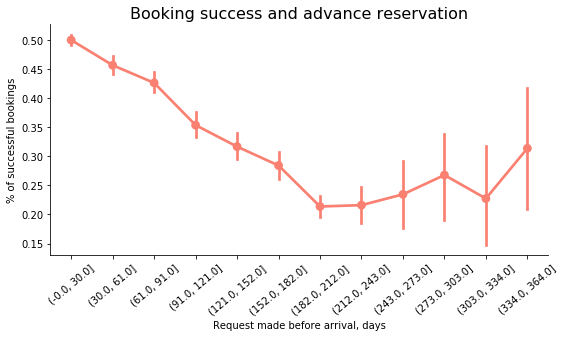

In [26]:
df['days_before_arrival_cut'] = pd.cut(df['request_days_before_arrival'], 12, precision=0)

g=sns.factorplot(x = 'days_before_arrival_cut', y='booked', data=df, size=4, aspect=2, color='salmon')
g.set_xticklabels(rotation=40)
plt.xlabel('Request made before arrival, days', color = "Black")
plt.ylabel('% of successful bookings', color = "Black")
plt.title('Booking success and advance reservation', fontsize = 16, color = "Black")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


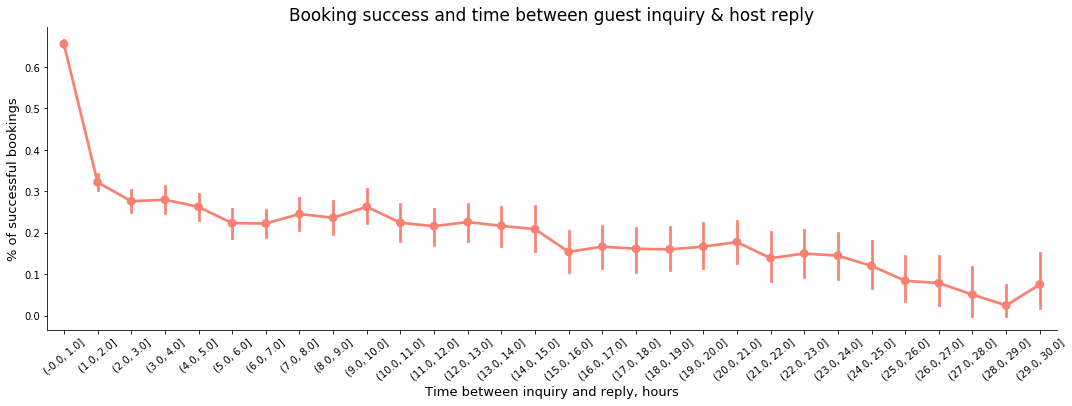

In [27]:
df_plot=df[df['time_interaction_reply']<30]
df_plot['time_interaction_reply_cut'] = pd.cut(df_plot['time_interaction_reply'], 30, precision=0)
g=sns.factorplot(x = 'time_interaction_reply_cut', y='booked', data=df_plot, size=5, aspect=3, color='salmon')
plt.xlabel('Time between inquiry and reply, hours', color = "Black", fontsize = 13)
plt.ylabel('% of successful bookings', color = "Black", fontsize = 13)
plt.title('Booking success and time between guest inquiry & host reply', fontsize = 17, color = "Black")
g.set_xticklabels(rotation=40)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


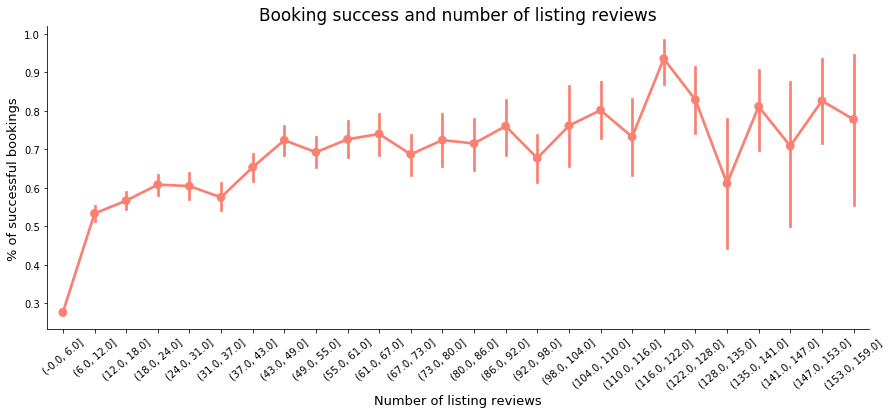

In [28]:
df_plot2 = df[df['total_reviews']<161]
df_plot2['reviews_cut'] = pd.cut(df_plot2['total_reviews'], 26, precision=0)
g=sns.factorplot(x = 'reviews_cut', y='booked', data=df_plot2, size=5, aspect=2.5, color='salmon')
plt.xlabel('Number of listing reviews', color = "Black", fontsize = 13)
plt.ylabel('% of successful bookings', color = "Black", fontsize = 13)
plt.title('Booking success and number of listing reviews', fontsize = 17, color = "Black")

g.set_xticklabels(rotation=40)

Text(0.5,1,'Booking success and party size')

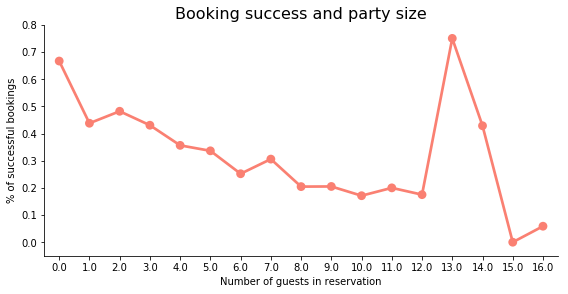

In [29]:
guest_number = df.groupby(['m_guests']).agg(\
                               {'id_guest_anon': 'count',
                                 'booked': 'mean'}).reset_index()
booking_stat.round(2)
g=sns.factorplot(x = 'm_guests', y='booked', data=guest_number, size=4, aspect=2, color='salmon')
plt.xlabel('Number of guests in reservation', color = "Black")
plt.ylabel('% of successful bookings', color = "Black")
plt.title('Booking success and party size', fontsize = 16, color = "Black")

# Regression

In [31]:
df.columns

Index(['id_guest_anon', 'id_host_anon', 'id_listing_anon',
       'ts_interaction_first', 'ts_booking_at', 'ds_checkin_first',
       'ds_checkout_first', 'm_guests', 'm_interactions',
       'm_first_message_length_in_characters', 'contact_channel_first',
       'guest_user_stage_first', 'room_type', 'listing_neighborhood',
       'total_reviews', 'country', 'words_in_user_profile', 'booked',
       'time_interaction_booking', 'time_interaction_reply',
       'time_reply_accepted', 'time_accepted_booking',
       'request_days_before_arrival', 'stay_length', 'inq_month',
       'days_before_arrival_cut'],
      dtype='object')

In [48]:
df['booked'] = 1 * df['booked']

In [101]:
import statsmodels.formula.api as sf

params = ['m_interactions', 'C(contact_channel_first)',  'total_reviews', \
          'time_interaction_reply','request_days_before_arrival', 'C(guest_user_stage_first)',\
          'stay_length','m_guests',\
          'm_first_message_length_in_characters', 'words_in_user_profile', 'C(room_type)', ]
list_of_r2 = []
for param in params:
    formula_1 = "booked ~ %s" % param
    model = sf.ols(formula_1, df)
    result = model.fit()
    list_of_r2.append((param, result.rsquared))
    

list_of_r2 

[('m_interactions', 0.1692369465870227),
 ('C(contact_channel_first)', 0.582769312026516),
 ('total_reviews', 0.08619005518881862),
 ('time_interaction_reply', 0.084778371286093),
 ('request_days_before_arrival', 0.04087403991451277),
 ('C(guest_user_stage_first)', 0.038854921352274974),
 ('stay_length', 0.02715581770198683),
 ('m_guests', 0.017332293077001792),
 ('m_first_message_length_in_characters', 0.012658175084026224),
 ('words_in_user_profile', 0.003165555590847524),
 ('C(room_type)', 0.004321469074903717)]

In [117]:
formula = "booked ~ m_interactions + m_guests  + total_reviews + "
formula += "m_first_message_length_in_characters + total_reviews + "
formula += "words_in_user_profile +time_interaction_reply + request_days_before_arrival+ stay_length + C(room_type)+"
formula += "C(contact_channel_first) + C(guest_user_stage_first)"
model = sf.ols(formula, df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 booked   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     3372.
Date:                Sun, 15 Jul 2018   Prob (F-statistic):               0.00
Time:                        15:39:44   Log-Likelihood:                -4650.1
No. Observations:               24757   AIC:                             9330.
Df Residuals:                   24742   BIC:                             9452.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.3548      0.054      6.612      0.000       0.250       0.460
C(room_type)[T.Private room]                 0.0124      0.005      2.623      0.009       0.003       0.022
C(room_type)[T.Shared room]                  0.0017      0.013      0.129      0.898      -0.024       0.027
C(contact_channel_first)[T.contact_me]      -0.3975      0.005    -85.467      0.000      -0.407      -0.388
C(contact_channel_first)[T.instant_book]     0.4143      0.005     80.800      0.000       0.404       0.424
C(guest_user_stage_first)[T.new]             0.1015      0.053      1.900      0.057      -0.003       0.206
C(guest_user_stage_first)[T.past_booker]     0.1119      0.053      2.095      0.036       0.007       0.217
m_interactions                               0.0107      0.000     55.795      0.000       0.010       0.011
m_guests                                    -0.0020      0.001     -1.853      0.064      -0.004       0.000
total_reviews                                0.0012   6.86e-05     16.868      0.000       0.001       0.001
m_first_message_length_in_characters      9.823e-06   1.06e-05      0.929      0.353   -1.09e-05    3.05e-05
words_in_user_profile                     2.735e-05   6.05e-05      0.452      0.651   -9.13e-05       0.000
time_interaction_reply                      -0.0022      0.000    -14.918      0.000      -0.003      -0.002
request_days_before_arrival                 -0.0005   2.68e-05    -17.816      0.000      -0.001      -0.000
stay_length                                 -0.0014      0.000     -6.594      0.000      -0.002      -0.001
==============================================================================
Omnibus:                     1569.925   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5590.073
Skew:                           0.250   Prob(JB):                         0.00
Kurtosis:                       5.274   Cond. No.                     1.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [79]:
corr = df.corr(method='pearson')
corr
corr.style.apply(lambda x: ["background: yellow" if (((v > 0.30) or (v < -0.30)) and \
                                                     (v != 1)) else "" for v in x], axis = 1)

,m_guests,m_interactions,m_first_message_length_in_characters,total_reviews,words_in_user_profile,booked,time_interaction_booking,time_interaction_reply,time_reply_accepted,time_accepted_booking,request_days_before_arrival,stay_length,inq_month
m_guests,1,-0.0431307,-0.0268153,-0.116636,-0.0834934,-0.131652,0.0577569,0.0872373,0.0469953,0.0377738,0.158254,-0.0692416,-0.0429608
m_interactions,-0.0431307,1,0.00257976,0.109185,0.0290955,0.411384,0.191829,-0.138729,0.0742897,0.164092,-0.074664,-0.00775792,0.0634117
m_first_message_length_in_characters,-0.0268153,0.00257976,1,0.0139026,0.143874,-0.112509,0.103744,0.0593884,0.0469622,0.0925567,0.0687697,0.130271,-0.0171514
total_reviews,-0.116636,0.109185,0.0139026,1,0.0425963,0.293581,-0.108976,-0.15164,-0.083166,-0.0536463,-0.118514,-0.122035,0.00825958
words_in_user_profile,-0.0834934,0.0290955,0.143874,0.0425963,1,0.0562633,-0.0391431,-0.0166056,-0.0230723,-0.0251052,-0.00485798,0.0140548,-0.000642184
booked,-0.131652,0.411384,-0.112509,0.293581,0.0562633,1,nan,-0.291167,-0.106369,nan,-0.202173,-0.16479,0.145912
time_interaction_booking,0.0577569,0.191829,0.103744,-0.108976,-0.0391431,nan,1,0.531399,0.706361,0.608558,0.0616424,0.122231,-0.0388489
time_interaction_reply,0.0872373,-0.138729,0.0593884,-0.15164,-0.0166056,-0.291167,0.531399,1,0.106636,0.0896425,0.130568,0.082067,-0.0658776
time_reply_accepted,0.0469953,0.0742897,0.0469622,-0.083166,-0.0230723,-0.106369,0.706361,0.106636,1,0.0281607,0.054271,0.0793815,-0.0264887
time_accepted_booking,0.0377738,0.164092,0.0925567,-0.0536463,-0.0251052,nan,0.608558,0.0896425,0.0281607,1,0.0237023,0.0927154,-0.00962732


In [115]:
from patsy import dmatrices
import statsmodels.api as sm
y, X = dmatrices(formula, df)
model_logistic = sm.Logit(y, X)
result_logistic = model_logistic.fit(maxiter=1000)
result_logistic.summary()

         Current function value: 0.216303
         Iterations: 2000


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 booked   No. Observations:                24757
Model:                          Logit   Df Residuals:                    24742
Method:                           MLE   Df Model:                           14
Date:                Sun, 15 Jul 2018   Pseudo R-squ.:                  0.6860
Time:                        15:36:41   Log-Likelihood:                -5355.0
converged:                      False   LL-Null:                       -17055.
                                        LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -1.5059      0.810     -1.859      0.063      -3.093       0.081
C(room_type)[T.Private room]                 0.0661      0.061      1.087      0.277      -0.053       0.185
C(room_type)[T.Shared room]                 -0.0658      0.163     -0.404      0.686      -0.385       0.254
C(contact_channel_first)[T.contact_me]      -3.0186      0.061    -49.600      0.000      -3.138      -2.899
C(contact_channel_first)[T.instant_book]    36.4768   1.23e+06   2.98e-05      1.000    -2.4e+06     2.4e+06
C(guest_user_stage_first)[T.new]             0.6949      0.808      0.860      0.390      -0.888       2.278
C(guest_user_stage_first)[T.past_booker]     0.8284      0.808      1.026      0.305      -0.755       2.411
m_interactions                               0.1812      0.004     44.598      0.000       0.173       0.189
m_guests                                    -0.0603      0.016     -3.779      0.000      -0.092      -0.029
total_reviews                                0.0154      0.001     15.277      0.000       0.013       0.017
m_first_message_length_in_characters         0.0001      0.000      0.849      0.396      -0.000       0.000
words_in_user_profile                      1.58e-05      0.001      0.021      0.983      -0.001       0.001
time_interaction_reply                      -0.0332      0.003    -11.425      0.000      -0.039      -0.027
request_days_before_arrival                 -0.0057      0.000    -14.723      0.000      -0.006      -0.005
stay_length                                 -0.0230      0.004     -6.477      0.000      -0.030      -0.016
============================================================================================================

Possibly complete quasi-separation: A fraction 0.27 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""